In [1]:
import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import gym
import neurogym as ngym

device = 'cuda' if torch.cuda.is_available() else 'cpu'

task = 'ContextDecisionMaking-v0'

In [2]:
def get_modelpath(task):
    # Make a local file directories
    path = Path('.') / 'files'
    os.makedirs(path, exist_ok=True)
    path = path / task
    os.makedirs(path, exist_ok=True)
    return path

modelpath = get_modelpath(task)

In [4]:
# Define networks
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math


class PosWLinear(nn.Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    Same as nn.Linear, except that weight matrix is constrained to be non-negative
    """
    __constants__ = ['bias', 'in_features', 'out_features']

    def __init__(self, in_features, out_features, bias=True):
        super(PosWLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        # weight is non-negative
        return F.linear(input, torch.abs(self.weight), self.bias)
    
    
class EIRecLinear(nn.Module):
    r"""Recurrent E-I Linear transformation.
    
    Args:
        hidden_size: int, layer size
        e_prop: float between 0 and 1, proportion of excitatory units
    """
    __constants__ = ['bias', 'hidden_size', 'e_prop']

    def __init__(self, hidden_size, e_prop, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.e_prop = e_prop
        self.e_size = int(e_prop * hidden_size)
        self.i_size = hidden_size - self.e_size
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        mask = np.tile([1]*self.e_size+[-1]*self.i_size, (hidden_size, 1))
        np.fill_diagonal(mask, 0)
        self.mask = torch.tensor(mask, dtype=torch.float32)
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # Scale E weight by E-I ratio
        self.weight.data[:, :self.e_size] /= (self.e_size/self.i_size)
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)
    
    def effective_weight(self):
        return torch.abs(self.weight) * self.mask

    def forward(self, input):
        # weight is non-negative
        return F.linear(input, self.effective_weight(), self.bias)


class EIRNN(nn.Module):
    """E-I RNN.
    
    Reference:
        Song, H.F., Yang, G.R. and Wang, X.J., 2016.
        Training excitatory-inhibitory recurrent neural networks
        for cognitive tasks: a simple and flexible framework.
        PLoS computational biology, 12(2).

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size)
        hidden: (batch, hidden_size)
        e_prop: float between 0 and 1, proportion of excitatory neurons
    """

    def __init__(self, input_size, hidden_size, dt=None,
                 e_prop=0.8, sigma_rec=0, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.e_size = int(hidden_size * e_prop)
        self.i_size = hidden_size - self.e_size
        self.num_layers = 1
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha
        # Recurrent noise
        self._sigma_rec = np.sqrt(2*alpha) * sigma_rec

        # self.input2h = PosWLinear(input_size, hidden_size)
        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = EIRecLinear(hidden_size, e_prop=0.8)

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return (torch.zeros(batch_size, self.hidden_size).to(input.device),
                torch.zeros(batch_size, self.hidden_size).to(input.device))

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        state, output = hidden
        total_input = self.input2h(input) + self.h2h(output)
        state = state * self.oneminusalpha + total_input * self.alpha
        state += self._sigma_rec * torch.randn_like(state)
        output = torch.relu(state)
        return state, output

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden[1])

        output = torch.stack(output, dim=0)
        return output, hidden


class Net(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Excitatory-inhibitory RNN
        self.rnn = EIRNN(input_size, hidden_size, **kwargs)
        # self.fc = PosWLinear(self.rnn.e_size, output_size)
        self.fc = nn.Linear(self.rnn.e_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        rnn_e = rnn_activity[:, :, :self.rnn.e_size]
        out = self.fc(rnn_e)
        return out, rnn_activity

In [6]:
config = {
    'dt': 100,
    'hidden_size': 128,
    'lr': .01,
    'batch_size': 16,
    'seq_len': 100,
    'envid': task,
}

timing = {
            'fixation': 300,
            # 'target': 350,
            'stimulus': 750,
            'delay': ngym.random.TruncExp(600, 300, 3000),
            'decision': 100
}

seq_len = 100
kwargs = {'dt': 100, 'timing': timing}

# Save config
with open(modelpath / 'config.json', 'w') as f:
    json.dump(config, f)

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

import torch.optim as optim
import numpy as np

# Instantiate the network and print information
hidden_size = 128
net = Net(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

Net(
  (rnn): EIRNN(
    (input2h): Linear(in_features=7, out_features=128, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=102, out_features=3, bias=True)
)


In [7]:
# Instantiate the network and print information
with torch.no_grad():
    net = Net(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
    net = net.to(device)
    net.load_state_dict(torch.load(modelpath / 'trained_net.pth'))
    
    perf = 0
    num_trial = 1000
    
    activity = list()
    info = pd.DataFrame()
    
    activity_dict = {}
    trial_infos = {}
    stim_activity = [[], []]  # response for ground-truth 0 and 1
    stim_activity_choice = [[],[],[]]  

    for i in range(num_trial):
        env.new_trial()
        ob, gt = env.ob, env.gt
        inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
        action_pred, rnn_activity = net(inputs)

        # Compute performance
        action_pred = action_pred.detach().numpy()
        choice = np.argmax(action_pred[-1, 0, :])
        correct = choice == gt[-1]

        # Log trial info
        trial_info = env.trial
        trial_info.update({'correct': correct, 'choice': choice})
        trial_infos[i] = trial_info
        info = info.append(trial_info, ignore_index=True)

        # Log stimulus period activity
        rnn_activity = rnn_activity[:, 0, :].detach().numpy()
        activity_dict[i] = rnn_activity

        # Compute stimulus selectivity for all units
        # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
        rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
        stim_activity_choice[env.trial['choice']].append(rnn_activity)
        activity.append(np.array(rnn_activity))

    print('Average performance', np.mean(info['correct']))

activity = np.array(activity)
info

Average performance 0.902


,choice,coh_0,coh_1,context,correct,ground_truth,other_choice
0,1.0,15.0,15.0,0.0,1.0,1.0,1.0
1,1.0,5.0,15.0,0.0,1.0,1.0,1.0
2,2.0,5.0,50.0,0.0,1.0,2.0,2.0
3,1.0,50.0,15.0,1.0,1.0,1.0,1.0
4,1.0,5.0,50.0,0.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...
995,2.0,15.0,15.0,1.0,1.0,2.0,1.0
996,1.0,15.0,50.0,1.0,1.0,1.0,1.0
997,1.0,50.0,5.0,0.0,1.0,1.0,1.0
998,1.0,50.0,50.0,1.0,1.0,1.0,1.0


In [8]:
def infer_test_timing(env):
    """Infer timing of environment for testing."""
    timing = {}
    for period in env.timing.keys():
        period_times = [env.sample_time(period) for _ in range(100)]
        timing[period] = np.median(period_times)
    return timing

In [9]:
info['coh_0'] = np.where((info['context'] == 0) & (info['ground_truth'] == 1), -info['coh_0'], info['coh_0'])
info['coh_1'] = np.where((info['context'] == 0) & (info['other_choice'] == 1), -info['coh_1'], info['coh_1'])
info['coh_0'] = np.where((info['context'] == 1) & (info['ground_truth'] == 1), -info['coh_0'], info['coh_0'])
info['coh_1'] = np.where((info['context'] == 1) & (info['ground_truth'] == 1), -info['coh_1'], info['coh_1'])


info

,choice,coh_0,coh_1,context,correct,ground_truth,other_choice
0,1.0,-15.0,-15.0,0.0,1.0,1.0,1.0
1,1.0,-5.0,-15.0,0.0,1.0,1.0,1.0
2,2.0,5.0,50.0,0.0,1.0,2.0,2.0
3,1.0,-50.0,-15.0,1.0,1.0,1.0,1.0
4,1.0,5.0,-50.0,0.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...
995,2.0,15.0,15.0,1.0,1.0,2.0,1.0
996,1.0,-15.0,-50.0,1.0,1.0,1.0,1.0
997,1.0,-50.0,-5.0,0.0,1.0,1.0,1.0
998,1.0,-50.0,-50.0,1.0,1.0,1.0,1.0


In [15]:
e_size = net.rnn.e_size

mean_activity0 = []
for coh in [-5, -15, -50, 5, 15, 50]:
    data = activity[(info['context'] == 0) & (info['coh_0'] == coh), :, :e_size]
    mean_act = np.concatenate(data, axis=0).mean(axis=0)
    mean_activity0.append(mean_act)

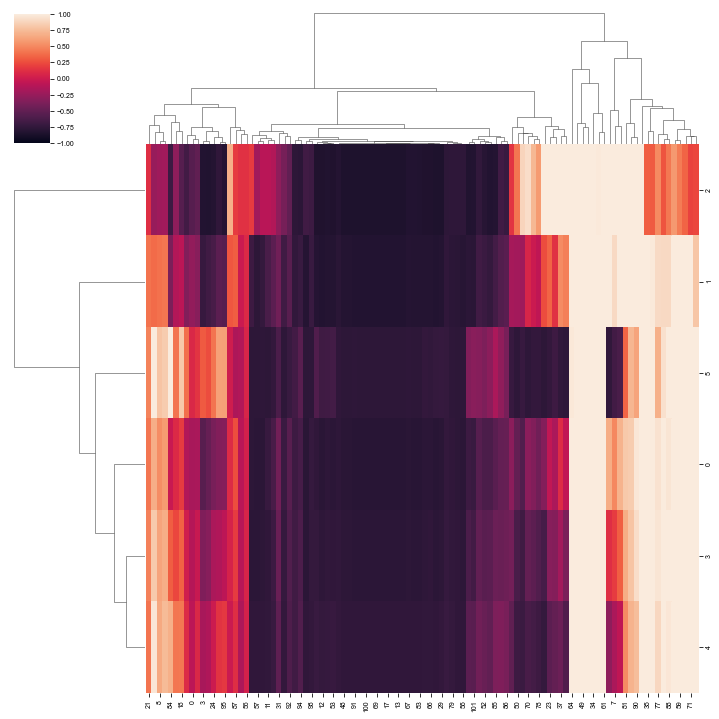

In [16]:
import seaborn as sns

g = sns.clustermap(mean_activity0, vmin=-1, vmax=1, z_score=0)